In [3]:
# -*- coding: utf-8 -*-
###
# Demonstration of MR reconstruction with CCP PET-MR Software
#
# This demonstration shows how to reconstruct MR images on a coil-by-coil basis
# and how to combine the image information from the different receiver coils
#
# This demo is a 'script', i.e. intended to be run step by step in a
# Python IDE such as spyder. It is organised in 'cells'. spyder displays these
# cells nicely and allows you to run each cell on its own.
#
# First version: 27th of May 2017
# Author: Christoph Kolbitsch
#

## CCP PETMR Synergistic Image Reconstruction Framework (SIRF).
## Copyright 2015 - 2017 Rutherford Appleton Laboratory STFC.
## Copyright 2015 - 2017 University College London.
## Copyright 2015 - 2017 Physikalisch-Technische Bundesanstalt.
##
## This is software developed for the Collaborative Computational
## Project in Positron Emission Tomography and Magnetic Resonance imaging
## (http://www.ccppetmr.ac.uk/).
##
## Licensed under the Apache License, Version 2.0 (the "License");
##   you may not use this file except in compliance with the License.
##   You may obtain a copy of the License at
##       http://www.apache.org/licenses/LICENSE-2.0
##   Unless required by applicable law or agreed to in writing, software
##   distributed under the License is distributed on an "AS IS" BASIS,
##   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
##   See the License for the specific language governing permissions and
##   limitations under the License.




In [4]:
__version__ = '0.1.0'

# import engine module
import pGadgetron as pMR

# import further modules
import os, numpy
%matplotlib
import matplotlib.pyplot as plt

Using matplotlib backend: TkAgg


In [5]:
#%% GO TO MR FOLDER
os.chdir(pMR.petmr_data_path('mr'))

In [6]:
# We define our first function: the FFT
def our_fft( k_array ):
    image_array = numpy.zeros(k_array.shape, numpy.complex128)
    for c in range(num_channels):
        image_array[:,c,:] = numpy.fft.fftshift( numpy.fft.ifft2( numpy.fft.ifftshift(k_array[:,c,:])))
    image_array = image_array/image_array.max()    
    return image_array
    

In [7]:
# LOADING AND PREPROCESSING DATA
acq_data = pMR.AcquisitionData('simulated_MR_2D_cartesian_Grappa2.h5')
preprocessed_data = pMR.preprocess_acquisition_data(acq_data)

In [8]:
# LET'S GET SOME INFORMATION FROM THE DATA
print('Is the data we loaded sorted? %s' % preprocessed_data.is_sorted())
print('Is the data we loaded undersampled? %s' % preprocessed_data.is_undersampled())

Is the data we loaded sorted? False
Is the data we loaded undersampled? 1


In [9]:
# OK SO LET'S SORT IT THEN
preprocessed_data.sort()
print('Is the data we loaded sorted? %s' % preprocessed_data.is_sorted())

Is the data we loaded sorted? True


In [10]:
#%% RETRIEVE K-SPACE DATA
k_array = preprocessed_data.as_array()
print('Size of k-space %dx%dx%d' % k_array.shape)

Size of k-space 160x8x256


Size of k-space 160x8x256


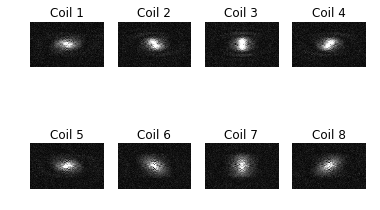

In [11]:
#%% SELECT VIEW DATA FROM DIFFERENT COILS
k_array = k_array[0:256,:,:]
print('Size of k-space %dx%dx%d' % k_array.shape)

num_channels = k_array.shape[1]

plt.close()
fig = plt.figure(1)
plt.set_cmap('gray')
for c in range(num_channels):
    ax = fig.add_subplot(2,4,c+1)
    ax.imshow(abs(k_array[:,c,:]), vmin=0, vmax=1)
    ax.set_title('Coil '+str(c+1))
    ax.axis('off')


In [12]:
# LETS GET SOME INFO IN THIS DATASET
which_readouts = preprocessed_data.get_info('kspace_encode_step_1')

sampling_mask = numpy.zeros([256,256])

for ro in which_readouts:
    sampling_mask[ro,:] = 1

(-0.5, 255.5, 159.5, -0.5)

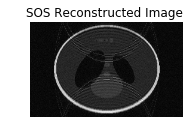

In [13]:
image_array = numpy.zeros(k_array.shape, numpy.complex128)
for c in range(num_channels):
    image_array[:,c,:] = numpy.fft.fftshift( numpy.fft.ifft2( numpy.fft.ifftshift(k_array[:,c,:])))
image_array = image_array/image_array.max()    
    
image_array_sos = numpy.sqrt( numpy.sum( numpy.square(image_array),1))
image_array_sos = image_array_sos/image_array_sos.max()

    
fig = plt.figure(3)
ax = fig.add_subplot(1,2,1)
ax.imshow(abs(image_array_sos), vmin=0, vmax=1)
ax.set_title('SOS Reconstructed Image ')
ax.axis('off')


### Question: Why does this look clinched? 
All the previous datasets were oval, what went "wrong" here?

(-0.5, 255.5, 255.5, -0.5)

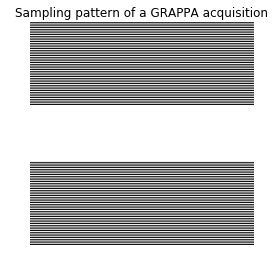

In [14]:
# NOW LET's PROCEED AND GET SOME INFO IN THIS DATASET
which_ro = preprocessed_data.get_info('kspace_encode_step_1')
sampling_mask = numpy.zeros([256,256])

for ro in which_ro:
    sampling_mask[ro,:] = 1

plt.close()
fig = plt.figure(1)
plt.set_cmap('gray')
ax = fig.add_subplot(1,1,1)
ax.imshow( sampling_mask, vmin=0, vmax=1)
ax.set_title('Sampling pattern of a GRAPPA acquisition')
ax.axis('off')


In [17]:
# QUICK INTERMEZZO: WE DEFINE A FUCTION:
def fft_and_sos( k_array ):
    image_array = numpy.zeros(k_array.shape, numpy.complex128)
    for c in range(num_channels):
        image_array[:,c,:] = numpy.fft.fftshift( numpy.fft.ifft2( numpy.fft.ifftshift(k_array[:,c,:])))
    image_array = image_array/image_array.max()    
    
    image_array_sos = numpy.sqrt( numpy.sum( numpy.square(image_array),1))
    image_array_sos = image_array_sos/image_array_sos.max()
    
    return image_array_sos

### Workaround: 'zero-fill' the k-space data
Since the shape of the data seems to be the problem, let's just change that shape into the one we want.

But can we just add datapoints? This will corrupt the data!

Actually, a Fourier transform is just a sum weighted by a phase. 

So it does not mind if we add zeros to it!

This means we make a larger array, add our data in the correct spots, and the gaps we fill with zeros. The correct spots are given by our sampling mask!

(-0.5, 255.5, 255.5, -0.5)

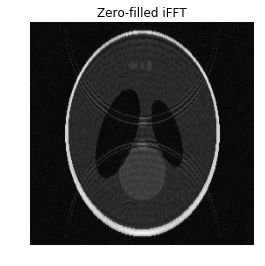

In [18]:
k_shape = [sampling_mask.shape[0], num_channels, sampling_mask.shape[1]]
zf_k_array = numpy.zeros(k_shape, numpy.complex128)

for i in range(k_array.shape[0]):
    zf_k_array[which_ro[i],:,:] = k_array[i,:,:]


zf_recon = fft_and_sos( zf_k_array)

fig = plt.figure(4)
ax = fig.add_subplot(1,1,1)
ax.imshow(abs(zf_recon), vmin=0, vmax=1)
ax.set_title('Zero-filled iFFT')
ax.axis('off')

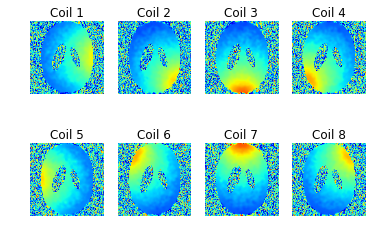

In [19]:
# WHICH COILMAPS DO WE GET FROM THIS DATASET?
csm = pMR.CoilSensitivityData()
csm.smoothness = 40
csm.calculate(preprocessed_data)
csm_array = numpy.squeeze(csm.as_array(0))

csm_array = csm_array.transpose([1,0,2])

fig = plt.figure(4)
plt.set_cmap('jet')
for c in range(csm_array.shape[1]):
    ax = fig.add_subplot(2,4,c+1)
    ax.imshow(abs(csm_array[:,c,:]))
    ax.set_title('Coil '+str(c+1))
    ax.axis('off')
plt.set_cmap('gray')

### Question: 
Why is it not important in estimating coilmaps, that
- we have only the center of the k-space sampled?
- there are artifacts in the reconstruction? Why are they not in the coilmaps?

---
 reconstructing...


(-0.5, 255.5, 255.5, -0.5)

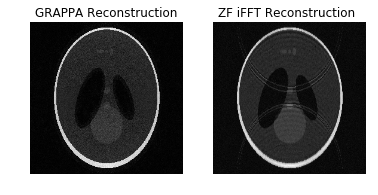

In [20]:
# NOW DO A GRAPPA RECONSTRUCTION

recon = pMR.CartesianGRAPPAReconstructor()
recon.set_input(preprocessed_data)
recon.compute_gfactors(False)
print('---\n reconstructing...')
recon.process()
# for undersampled acquisition data GRAPPA computes Gfactor images
# in addition to reconstructed ones
grappa_images = recon.get_output()
grappa_images_array = grappa_images.as_array()
grappa_images_array = grappa_images_array/grappa_images_array.max()

fig = plt.figure(4)
ax = fig.add_subplot(1,2,1)
ax.imshow(abs(grappa_images_array[0,:,:]), vmin=0, vmax=1)
ax.set_title('GRAPPA Reconstruction')
ax.axis('off')

ax = fig.add_subplot(1,2,2)
ax.imshow(abs(zf_recon), vmin=0, vmax=1)
ax.set_title('ZF iFFT Reconstruction ')
ax.axis('off')


### Question:
Well, that was very little code to perform a difficult task!

In what respect did a GRAPPA reconstruction:

 * improve the resulting image?
 * deterioate the resulting image?

# URGH!
## We are annoyed at how much code we have to write all the time.
## Enter: AcquisitionModel

In the literature usually an acquisition model is called $E$, E for encoding.  
We want to capture our entire imaging and reconstruction process in one single object and don't care about data structure.  
For an image $x$, k-space data set $y$ we want to be able to go 
$$ E: x \rightarrow y $$
(forward) and 
$$ E^H: y \rightarrow x $$
(backward).  
Also we don't want to have to sum over coils and care for zero-filling and all that.


In [26]:
# NOW LET'S GENERATE THE E OPERATOR FROM ABOVE

E = pMR.AcquisitionModel(preprocessed_data, grappa_images)
E.set_coil_sensitivity_maps(csm)

# done, now we can hop back and forth
ifft_image = E.backward( preprocessed_data )
ifft_image_array = ifft_image.as_array()

### BEFORE YOU RUN THE NEXT CELL AND LOOK AT THE PLOT:
What do you expect the reconstruction to look like?
- Is it clinched or is it the correct size?
- Does it contain artifacts? If so, which ones?

(-0.5, 255.5, 255.5, -0.5)

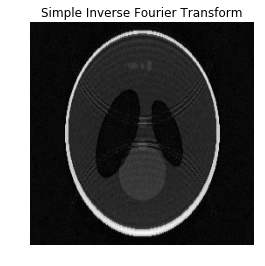

In [28]:
plt.set_cmap('gray')
fig = plt.figure(5)
ax = fig.add_subplot(1,1,1)
ax.imshow(abs(ifft_image_array[0,:,:]))
ax.set_title('Simple Inverse Fourier Transform')
ax.axis('off')

# Conjugate Gradient SENSE
## Iterative Parallel Imaging Reconstruction

In order to reconstruct images we want to achieve the following equality:
$$ E \tilde{x} = y $$,
where $E$ is the encoding operator $\tilde{x}$ is the true image object and $y$ is the MR raw data. 
The task of image reconstruction boils down to optimizing the following function:
$$ \mathcal{C}(x) = \frac{1}{2} \bigl{|} \bigl{|}  E x - y \bigr{|} \bigr{|}_2  \\
\tilde{x} = \min_x \mathcal{C}(x)
$$

## Gameplan: Perform Iterative SENSE

For that we need to write a bit of code:
- A cost function.
- We already have this encoding operator E defined and it does what it should.
- We still need to define what 